In [1]:
from astropy.io import fits

In [2]:
import astropy.units as u
import astropy.constants
from astropy.coordinates import SkyCoord

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
from astropy.visualization import quantity_support
quantity_support();

In [6]:
%matplotlib inline

Data from http://vizier.cfa.harvard.edu/viz-bin/VizieR-2?-source=+VIII%2F76%2Fbvmaps&-from=nav&-nav=cat%3AVIII%2F76%26tab%3A%7BVIII%2F76%2Fbvmaps%7D%26key%3Asource%3DVIII%2F76%26HTTPPRM%3A%26

In [7]:
fitsdata = fits.open("labh.fit")[0]

In [8]:
v0 = fitsdata.header.cards['CRVAL3'][1]*u.m/u.s

In [9]:
v0

<Quantity -458604.5262155 m / s>

In [10]:
vincr = fitsdata.header.cards['CDELT3'][1]*u.m/u.s

In [11]:
data = fitsdata.data

In [12]:
data.shape

(891, 361, 721)

In [13]:
def frame_to_v(frame_nr):
    return v0 + frame_nr*vincr

In [14]:
((0*u.m/u.s - v0)/vincr).value # Frame with rest frequency

445.0000000101885

In [15]:
def v_to_frame(v):
    return round(((v*u.m/u.s - v0)/vincr).value)

In [16]:
def lb_to_xy(l, b):
    """Convert galactic longitude, latitude to pixel coordinates
    
    Args:
        (l, b) (Tuple[int, int]): latitude and longitude in degrees
        
    Returns:
        Tuple[int, int]: x and y coordinates, x from 0 to 720, y from 0 to 360
    """
    return (2*((180-l)%360), 2*(b+90))

In [17]:
def skycoord_to_xy(coord):
    """Convert a skycoord to x and y pixel coordinates"""
    l = round(coord.galactic.l.to(u.deg).value)
    b = round(coord.galactic.b.to(u.deg).value)
    return lb_to_xy(l, b)

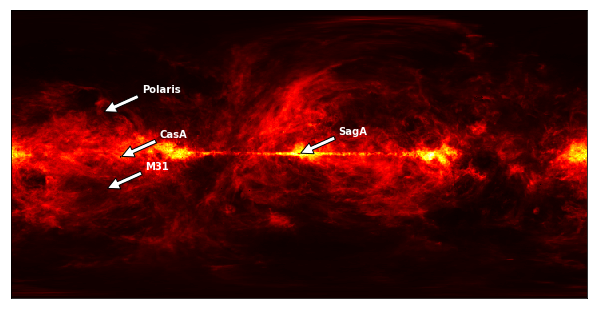

In [18]:
fig, ax = plt.subplots(figsize=(8, 16/data.shape[2]*data.shape[1]))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(data[v_to_frame(0),:,:], cmap='hot', vmin=0, vmax=151, origin='lower')
objs = ["SagA", "CasA", "Polaris", "M31"]
for obj in objs:
    ax.annotate(obj, xy=skycoord_to_xy(SkyCoord.from_name(obj)),
                xytext=(40, 20), textcoords='offset points',
                arrowprops=dict(facecolor='white', shrink=0.05), color='white',
                weight='bold'
                );

In [19]:
data.shape

(891, 361, 721)

In [20]:
velocities = np.arange(v0.value, v0.value+891*vincr.value, vincr.value) * v0.unit

In [24]:
def get_line_data(skycoord):
    x, y = skycoord_to_xy(skycoord)
    return data[:, y, x]

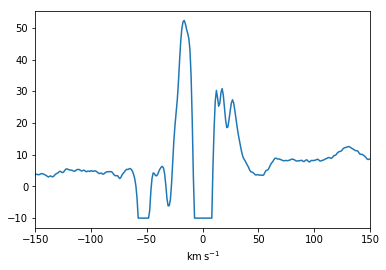

In [31]:
plt.plot(velocities.to(u.km/u.s), get_line_data(SkyCoord.from_name("SagA")));
plt.xlim([-150,150]);

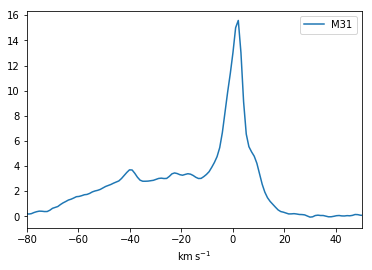

In [39]:
m31 = SkyCoord.from_name("M31")
plt.plot(velocities.to(u.km/u.s), get_line_data(m31), label="M31");
#plt.plot(velocities.to(u.km/u.s), data[:, 180+b0, 2*(l0-1)], label="M31 - 0.5 deg");
#plt.plot(velocities.to(u.km/u.s), data[:, 180+b0, 2*(l0+1)], label="M31 + 0.5 deg");
plt.xlim([-80,50]);
plt.legend();

In [40]:
def vlsr_to_freq(vlsr):
    """Convert speed to frequency"""
    freq_hi = 1420.405751 * u.MHz
    # TODO: should the plus be a minus?
    return freq_hi * (1 + vlsr/astropy.constants.c)

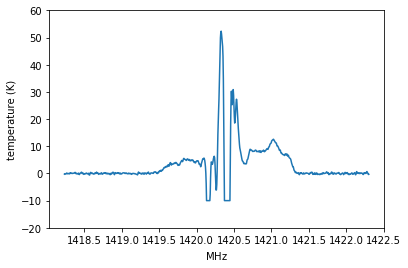

In [77]:
fig, ax = plt.subplots()
ax.plot(vlsr_to_freq(velocities.to(u.km/u.s)),
        get_line_data(SkyCoord.from_name("SagA")));
ax.set_ylim(-20,60);
ax.set_ylabel("temperature (K)");

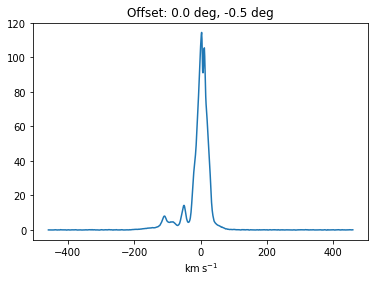

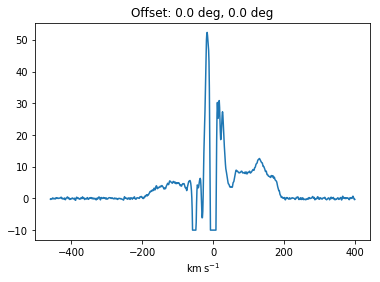

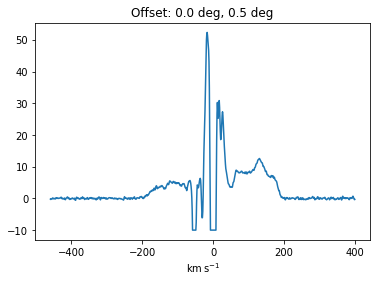

<Figure size 432x288 with 0 Axes>

In [80]:
m31 = SkyCoord.from_name("SagA")
l0, b0 = m31.galactic.l, m31.galactic.b
for delta_l in [0*u.deg]:
    for delta_b in [-0.5*u.deg, 0*u.deg, +0.5*u.deg]:
        coord = SkyCoord(frame='galactic', l=l0+delta_l, b=b0+delta_b)
        plt.plot(velocities.to(u.km/u.s), get_line_data(coord));
        plt.title("Offset: "+str(delta_l)+", "+str(delta_b));
        plt.figure();